## 多分类皮肤病预测

### 数据预处理

数据说明：http://archive.ics.uci.edu/ml/machine-learning-databases/dermatology/dermatology.names

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb

#33: lambda x:int(x == '?') 将第33列?转化为1 ，对应第34列数值缩减以0开始
data = np.loadtxt('dermatology.data.txt', delimiter=',',converters={33: lambda x: x if str(x).isdigit()  else int(x=="?") , 34: lambda x:int(x)-1} )
data.shape

(366, 35)

In [1]:
list1=[12,"?",16]
list(map(lambda x:x if str(x).isdigit()  else int(x=="?") , list1))   #isdigit() 字符是否全为数字

[12, 1, 16]

### 模型构建、类别预测、评估

In [3]:
X,Y=data[:,0:33],data[:,34]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
#加载numpy的数组到DMatrix对象
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix( X_test, label=y_test)
#1.训练模型
# setup parameters for xgboost


param={'booster':'gbtree',
    'objective':  'multi:softmax',
    'num_class':6,  #分类数
    'max_depth':5,
    'lambda':10,
    'subsample':0.75,
    'colsample_bytree':0.75,
    'min_child_weight':2,
    'eta': 0.1,
    'seed':0,
    'nthread':4,
    'silent':1
       }

watchlist = [ (xg_train,'train'),(xg_test,'test') ]
num_round =6
bst = xgb.train(param, xg_train, num_round, watchlist )

y_pred = bst.predict( xg_test );
print(y_pred)

#混淆矩阵
from sklearn import metrics
print(metrics.confusion_matrix(y_test,y_pred))


[0]	train-merror:0.140625	test-merror:0.218182
[1]	train-merror:0.054688	test-merror:0.054545
[2]	train-merror:0.0625	test-merror:0.054545
[3]	train-merror:0.027344	test-merror:0.045455
[4]	train-merror:0.023438	test-merror:0.045455
[5]	train-merror:0.023438	test-merror:0.045455
[ 3.  3.  2.  5.  2.  5.  1.  0.  5.  4.  1.  0.  4.  1.  4.  0.  0.  4.
  3.  3.  0.  1.  1.  0.  2.  2.  4.  3.  2.  2.  0.  0.  3.  1.  4.  1.
  0.  2.  4.  1.  0.  3.  2.  3.  5.  0.  2.  2.  5.  2.  0.  3.  0.  1.
  4.  0.  0.  0.  3.  1.  2.  3.  2.  1.  2.  5.  1.  0.  3.  1.  3.  2.
  2.  4.  0.  0.  3.  0.  0.  0.  1.  2.  1.  2.  3.  4.  0.  4.  1.  1.
  2.  4.  0.  1.  4.  3.  1.  0.  4.  1.  4.  1.  4.  0.  0.  2.  2.  0.
  0.  3.]
[[27  0  0  0  0  0]
 [ 0 19  0  1  0  0]
 [ 0  0 21  0  0  0]
 [ 0  2  0 16  0  0]
 [ 0  0  0  0 16  0]
 [ 2  0  0  0  0  6]]


### 预测概率

In [4]:
param['objective'] = 'multi:softprob'    # p
bst = xgb.train(param, xg_train, num_round, watchlist )
yprob = bst.predict( xg_test ).reshape( y_test.shape[0], 6 )    #将每一组的预测转化为在一个array中
yprob

[0]	train-merror:0.140625	test-merror:0.218182
[1]	train-merror:0.054688	test-merror:0.054545
[2]	train-merror:0.0625	test-merror:0.054545
[3]	train-merror:0.027344	test-merror:0.045455
[4]	train-merror:0.023438	test-merror:0.045455
[5]	train-merror:0.023438	test-merror:0.045455


array([[ 0.13192585,  0.19992904,  0.12990849,  0.27992001,  0.12926041,
         0.12905619],
       [ 0.13311026,  0.19274618,  0.13107477,  0.28243309,  0.13042088,
         0.13021483],
       [ 0.1266015 ,  0.1308295 ,  0.34435049,  0.15032721,  0.12404362,
         0.12384765],
       [ 0.14200187,  0.15211381,  0.18584228,  0.16170046,  0.13466777,
         0.22367376],
       [ 0.11602154,  0.19342652,  0.31557345,  0.14780322,  0.11367742,
         0.11349782],
       [ 0.15513898,  0.15581681,  0.13863771,  0.16388214,  0.13794607,
         0.24857828],
       [ 0.14926769,  0.27923754,  0.14032108,  0.15215215,  0.13962106,
         0.13940047],
       [ 0.37716922,  0.12665118,  0.12163164,  0.13103868,  0.12102485,
         0.12248444],
       [ 0.14851862,  0.19184132,  0.13272151,  0.15688868,  0.1320594 ,
         0.23797052],
       [ 0.13340566,  0.14245281,  0.13136566,  0.14144211,  0.32083002,
         0.1305038 ],
       [ 0.15652056,  0.24600515,  0.14669991,  0.

In [5]:
a = np.arange(6).reshape((3, 2))
a

array([[0, 1],
       [2, 3],
       [4, 5]])

### 类别转化概率

In [7]:
#从预测的6组中选择最大的概率进行输出
ylabel = np.argmax(yprob, axis=1)  # return the index of the biggest pro
ylabel

array([3, 3, 2, 5, 2, 5, 1, 0, 5, 4, 1, 0, 4, 1, 4, 0, 0, 4, 3, 3, 0, 1, 1,
       0, 2, 2, 4, 3, 2, 2, 0, 0, 3, 1, 4, 1, 0, 2, 4, 1, 0, 3, 2, 3, 5, 0,
       2, 2, 5, 2, 0, 3, 0, 1, 4, 0, 0, 0, 3, 1, 2, 3, 2, 1, 2, 5, 1, 0, 3,
       1, 3, 2, 2, 4, 0, 0, 3, 0, 0, 0, 1, 2, 1, 2, 3, 4, 0, 4, 1, 1, 2, 4,
       0, 1, 4, 3, 1, 0, 4, 1, 4, 1, 4, 0, 0, 2, 2, 0, 0, 3], dtype=int64)

### 模型评估

In [8]:
from sklearn import metrics
print ('ACC: %.4f' % metrics.accuracy_score(y_test,ylabel))
print(metrics.confusion_matrix(y_test,ylabel))

ACC: 0.9545
[[27  0  0  0  0  0]
 [ 0 19  0  1  0  0]
 [ 0  0 21  0  0  0]
 [ 0  2  0 16  0  0]
 [ 0  0  0  0 16  0]
 [ 2  0  0  0  0  6]]


### 特征重要度

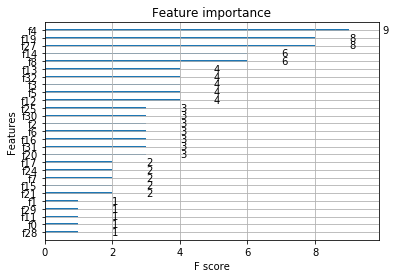

In [9]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
# 显示重要特征
plot_importance(bst)
plt.show()

In [10]:
[i for i in range(1,25,5)]

[1, 6, 11, 16, 21]

In [11]:
from sklearn.model_selection import GridSearchCV

# cv_params = {'n_estimators': [400, 500, 600, 700, 800]}
cv_params = {'min_child_weight': range(1,10,2),'n_estimators':[400,500, 600, 700, 800]}

other_params ={
    'booster':'gbtree',
    'objective':  'multi:softmax',
    'subsample':0.75,
    'lambda':1,
    'max_depth':5,
    'colsample_bytree':0.75,
    'min_child_weight':2,
    'eta': 0.025,
    'seed':0,
    'nthread':8,
     'silent':1
}
model = xgb.XGBClassifier(**other_params)    #**不能省略,不定长传参
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.grid_scores_
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
# print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  2.7min finished


每轮迭代运行结果:[mean: 0.92078, std: 0.05712, params: {'min_child_weight': 1, 'n_estimators': 400}, mean: 0.92078, std: 0.05712, params: {'min_child_weight': 1, 'n_estimators': 500}, mean: 0.92078, std: 0.05712, params: {'min_child_weight': 1, 'n_estimators': 600}, mean: 0.92078, std: 0.05712, params: {'min_child_weight': 1, 'n_estimators': 700}, mean: 0.92078, std: 0.05712, params: {'min_child_weight': 1, 'n_estimators': 800}, mean: 0.95734, std: 0.03797, params: {'min_child_weight': 3, 'n_estimators': 400}, mean: 0.93191, std: 0.05250, params: {'min_child_weight': 3, 'n_estimators': 500}, mean: 0.92714, std: 0.05665, params: {'min_child_weight': 3, 'n_estimators': 600}, mean: 0.92555, std: 0.05833, params: {'min_child_weight': 3, 'n_estimators': 700}, mean: 0.92714, std: 0.05665, params: {'min_child_weight': 3, 'n_estimators': 800}, mean: 0.90514, std: 0.08243, params: {'min_child_weight': 5, 'n_estimators': 400}, mean: 0.90514, std: 0.08243, params: {'min_child_weight': 5, 'n_estimators': 

F:\Anaconda3\Ana3.5.1\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [ ]:
QQ:595454159